Import potentially useful libraries.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load CSV file into DataFrames, 'survey' and 'interview'. Display the first 5 rows to verify they loaded correctly and to understand their structures.

In [5]:
survey = pd.read_csv('./survey_or.csv')
interview = pd.read_csv('./Stakeholders_FRs_Bens.csv')
notebooks = pd.read_csv('./Notebook_new.csv')

# 'interview' DataFrame Preprocess

1. Remove three columns,'Comms ID', 'Stakeholder ID','TL-01'.
2. Rename the column 'Comms date' to 'Date'.
3. Convert the 'Date' column to datetime format.
4. Convert specified columns to string type and removes any occurrences of \n\r.
5. Encodes non-null value to 2 and each null value to 0, except the first column 'Date', and stores the result in interview_L1, except column 'Date'.

> Unlike the ‘survey’, which is divided into 3 categories, in the ‘interview’ DataFrame, we assume all atrributes in 6 blocks are asked. Any object with a specific response indicates that the respondent considers the level1 attribute ‘essential’, and is encoded as 2. If there is no response, it is defaulted to 'Not Required' and encoded as 0.

6. Drop  the column 'IT-01' because we relegate the ‘API’ functional attribute to below the top-level, and to instead be a feature of ‘Automation’.
   

In [7]:
interview = interview.drop(columns=['Comms ID', 'Stakeholder ID','TL-01'])

interview.rename(columns={'Comms date':'Date'},inplace = True)
interview['Date'] = pd.to_datetime(interview['Date'],format='%d/%m/%Y')

cols= [
    'G-01', 'U-01', 'U-02', 'U-03', 'CF-01', 'CF-02', 'CF-04', 
    'CF-05', 'CF-06', 'CF-07', 'C-01', 'C-02', 'EF-01', 'EF-02', 
    'EF-03', 'EF-05', 'EF-06', 'IT-01', 'IT-02', 'IT-03', 'IT-04'
]

for col in cols:
    interview[col] = interview[col].astype('string')
    interview[col]=interview[col].str.replace('\n\r',' ')

interview_L1 = interview.iloc[:,1:].map(lambda x: 2 if pd.notnull(x) else 0)
interview_L1 = pd.concat([interview.iloc[:, :1], interview_L1], axis=1)
interview_L1.drop(columns='IT-01',inplace=True)

interview_L1.columns

Index(['Date', 'G-01', 'U-01', 'U-02', 'U-03', 'CF-01', 'CF-02', 'CF-04',
       'CF-05', 'CF-06', 'CF-07', 'C-01', 'C-02', 'EF-01', 'EF-02', 'EF-03',
       'EF-05', 'EF-06', 'IT-02', 'IT-03', 'IT-04'],
      dtype='object')

# 'survey' DataFrame Preprocess

- Level1 questions: Q3.1, Q4.2, Q5.2, Q6.2, Q7.2, Q8.2

- Level2 questions: Q3.2, Q4.3, Q4.4, Q5.3, Q5.4, Q5.5, Q5.6, Q5.7, Q5.8, Q6.3, Q6.4, Q7.3, Q7.4, Q7.18, Q7.20, Q7.21, Q8.3, Q8.4, Q8.5

- Level3 questions: Q3.3, Q7.6 - Q7.17, 7.19

> The complete sample includes survey respondents who have finished at least 3 out of the 6 blocks. However, we include all respondents, regardless of completion status, because each block is independent. This allows us to calculate the response count for each question individually, ensuring statistical reliability and increasing the overall sample size.)

1. Remove the first row and reseting index.
1. Uses 'EndDate' as the column 'Date' that match with 'Date' in 'interview' column.
2. Renames columns in 'survey' to match with 'interview' DataFrame.
3. Removes time in the 'Date' column.
4. Transforms ordered categorical values ( 'Essential', 'Nice to Have', 'Not Required') into numerical values (2, 1, 0) based on the importance dictionary and converts them to integer type, then selecting the range of columns from Q3.1 to Q8.2_3 in the ‘survey’ DataFrame to view.

In [9]:
survey = survey.iloc[1:].reset_index(drop=True)

level1 = ['Q3.1','Q4.2_1','Q4.2_2','Q4.2_3','Q5.2_1','Q5.2_2','Q5.2_3','Q5.2_4','Q5.2_5','Q5.2_6',
          'Q6.2_1','Q6.2_2','Q7.2_1','Q7.2_2','Q7.2_3','Q7.2_4','Q7.2_5','Q8.2_1','Q8.2_2','Q8.2_3']

level1_new = ['G-01', 'U-01', 'U-02', 'U-03', 'CF-01', 'CF-02', 'CF-04',
       'CF-05', 'CF-06', 'CF-07', 'C-01', 'C-02', 'EF-01', 'EF-02', 'EF-03',
       'EF-05', 'EF-06', 'IT-02', 'IT-03', 'IT-04']

rename_dict = dict(zip(level1,level1_new))
survey_L1 = survey[['EndDate'] + level1].copy()
survey_L1.rename(columns=rename_dict, inplace=True)
survey_L1.rename(columns={'EndDate':'Date'}, inplace=True)


survey_L1['Date'].astype('string')
survey_L1['Date']=survey_L1['Date'].str.split(' ').str[0]
survey_L1['Date'] = pd.to_datetime(survey_L1['Date'],format='%d/%m/%Y')


importance = {'Essential':2,'Nice to Have':1,'Not Required':0}
for col in level1_new:
    survey_L1[col]=survey_L1[col].map(importance).astype('Int64')

# Weights of Level 1

1. Concatenate the two dataframes ‘interview_L1’ and ‘survey_L1' vertically, sorts it by the 'Date' column in ascending order.
2. Calculate the total score of level1 attributes, and the probability of each level1 question occurring.
3. Compute the normalized weights for each level1 attributes based on the total score and the probability.

In [11]:
Whole_L1 = pd.concat([interview_L1,survey_L1],axis=0,ignore_index=True)
Whole_L1 = Whole_L1.sort_values('Date', ascending=True)

total_score = Whole_L1[level1_new].sum()

answer_count = Whole_L1[level1_new].count()

total_count = answer_count.sum()
L1_probability = round(answer_count/total_count, 4)

Weight_L1 = round((total_score/L1_probability)/sum(total_score/L1_probability),4)

L1_weight = dict(Weight_L1)
L1_weight


{'G-01': 0.0143,
 'U-01': 0.0428,
 'U-02': 0.0095,
 'U-03': 0.0595,
 'CF-01': 0.0791,
 'CF-02': 0.0571,
 'CF-04': 0.0615,
 'CF-05': 0.0725,
 'CF-06': 0.0922,
 'CF-07': 0.0769,
 'C-01': 0.0594,
 'C-02': 0.0251,
 'EF-01': 0.0457,
 'EF-02': 0.0549,
 'EF-03': 0.0366,
 'EF-05': 0.0411,
 'EF-06': 0.0526,
 'IT-02': 0.013,
 'IT-03': 0.0441,
 'IT-04': 0.0622}

# Weights of Level 2

1. Define a function 'sub_weight' for non-quantitative survey questions to calculate the weights of each element that affect level1 attributes in each block..
2. Define a function 'sub_weight_num' for quantitative survey questions to calculate the weights.
  
> Based on the survey's 100-point scoring criteria, any element presented in'interview will be considered essential and scored as 100. Elements not presented will be deemed not required and scored as 0. In the survey, missing values indicate the absence of any value, we need to calculate the average for each element. This is because, in the survey, the number of participants scoring each element is different.- quan questions

3. Calculate weights of level 2 using functions.

In [62]:
def sub_weight( int_col,sur_col,replacements=None):
    
    Block_L2 = pd.DataFrame()
    Block_L2['L2'] = pd.concat([int_col,sur_col.astype('string')],ignore_index=True)
    if replacements is None:
        replacements = {}
    for old_value, new_value in replacements.items():
        Block_L2['L2']=Block_L2['L2'].str.replace(old_value, new_value)
        
    sub_count = {}
    
    for value in Block_L2['L2']:
        if pd.notna(value):
            items = value.split(',')
            for item in items:
                item = item.strip()
                if item in sub_count:
                    sub_count[item] += 1
                else:
                    sub_count[item] = 1
    
    weight_dic = {}
    total = sum(sub_count.values())
    for key in sub_count:
        weight_dic[key] = round(sub_count[key] / total, 4)
    
    return weight_dic

In [14]:
def sub_weight_num(intv_col,surv_col,start, end,renames):

    survey_L2 = survey[surv_col=='Essential']
    start = survey_L2.columns.get_loc(start)
    end = survey_L2.columns.get_loc(end)

    survey_L2=survey_L2.iloc[:,start:end+1]

    survey_L2.rename(columns=renames,inplace=True)
    for col in survey_L2.columns:
        survey_L2[col]=pd.to_numeric(survey_L2[col],errors='coerce').astype('Int64')

    elem_num = intv_col.shape[0] + survey_L2.count()

    sub_count = {}
    
    for value in intv_col:
        if pd.notna(value):
            items = value.split(',')
            for item in items:
                item = item.strip()
                if item in sub_count:
                    sub_count[item] += 1
                else:
                    sub_count[item] = 1
                   
    intv_count = sub_count
    intv_score = pd.Series({key.strip():value for key, value in intv_count.items()})*100
    surv_score = survey_L2.sum()
    total_score = surv_score.add(intv_score,fill_value=0).astype('Int64')
    elem_mean = total_score/elem_num
    weight_num = dict(round(elem_mean/elem_mean.sum(),4))
    
    return weight_num

In [15]:
### Block1_L2
#'G-01'-Licence: survey: Q3.2 | interview: G-01
interview['G-01-L2'] = interview['G-01'].apply(
    lambda x: "Yes" if isinstance(x, str) and x != 'Closed Source' else ("No" if isinstance(x, str) and x == 'Closed Source' else pd.NA))

G_01_L2_weight = sub_weight(interview['G-01-L2'],survey['Q3.2'],)

###Block2_L2
#'U-02'-Languages: survey: Q4.3_1 | interview: U-02
U_02_L2_weight = sub_weight(interview['U-02'],survey['Q4.3_1'],)

#U-03'-Support: survey: Q4.4 | interview: U-03 
replacements = {'User training (online, on site)':'User training (online/on site)',
                'Online vendor documentation':'Online documentation',
               'Vendor-supplied training':'User training (online/on site)',
               'Vendor consultation':'Support by provider (Consulting)'}

U_03_L2_weight = sub_weight(interview['U-03'],survey['Q4.4'],replacements)

###Block3_L2
#'CF-01'-Data input: survey: Q5.3_1-Q5.3_16 | interview: CF-01 (quanti)
renames = {'Q5.3_1':'Annotation','Q5.3_2':'Barcode Scanner','Q5.3_3':'Browser forms',
                  'Q5.3_4':'Chemical editor/sketching','Q5.3_5':'Dictation function','Q5.3_6':'Freehand/Sketches',
                  'Q5.3_7':'HELM editor','Q5.3_8':'Mathematical formula/equation editor','Q5.3_9':'Plain text editor',
                 'Q5.3_10':'Rich text editor','Q5.3_11':'Scientific calculator','Q5.3_12':'Symbolic link','Q5.3_13':'Table editor',
                 'Q5.3_14':'With internal links','Q5.3_15':'With external links','Q5.3_16':'XHTML-Editor'}

CF_01_L2_weight = sub_weight_num(interview['CF-01'],survey['Q5.2_1'],'Q5.3_1', 'Q5.3_16',renames)

#'CF-02'-Data import (formats): survey:Q5.4_1-Q5.4_10 | interview: CF-02 (quanti)
renames = {'Q5.4_1':'Audio formats','Q5.4_2':'Database formats','Q5.4_3':'Document formats',
                  'Q5.4_4':'Image formats','Q5.4_5':'MS Office formats','Q5.4_6':'Packed formats',
                  'Q5.4_7':'Scientific formats','Q5.4_8':'Structured formats','Q5.4_9':'Table formats',
                 'Q5.4_10':'Video formats'}

CF_02_L2_weight = sub_weight_num(interview['CF-02'],survey['Q5.2_2'],'Q5.4_1', 'Q5.4_10',renames)

#'CF-04'-Data export: survey:Q5.5 | interview: CF-04
replacements = {'All content in a document format':'Complete content in document format',
                'All content in a structured, machine-readable format':'Complete content in machine readable format',
               'A subset of content in a structured, machine-readable format':'Formats suitable for long term archiving',
               'A subset of content in a document format':'Formats suitable for publication'}

CF_04_L2_weight = sub_weight(interview['CF-04'],survey['Q5.5'],replacements)

#'CF-05'-Templates: survey:Q5.6 | interview: CF-05
replacements = {'Define own templates':'Definition/import of own templates',
                'Import of own templates':'Definition/import of own templates',
               'Import from internet sources (i.e. protocols.io)':'Import of own templates',
                'Other subject-specific templates (please specify)':'Subject specific templates'}

CF_05_L2_weight = sub_weight(interview['CF-05'],survey['Q5.6'],replacements)

#'CF-06'-Searchability: survey:Q5.7_1-Q5.7_9 | interview: CF-06
renames = {'Q5.7_1':'Advanced/conditional search','Q5.7_2':'BLAST Search','Q5.7_3':'Database queries',
                  'Q5.7_4':'File/data hierarchy','Q5.7_5':'Filtering','Q5.7_6':'Full text search',
                  'Q5.7_7':'Search by command line','Q5.7_8':'Search for reactions by chemical structure','Q5.7_9':'Tagging'}

CF_06_L2_weight = sub_weight_num(interview['CF-06'],survey['Q5.2_5'],'Q5.7_1', 'Q5.7_9',renames)

#'CF-07'-Collaboration: survey:Q5.8_1-Q5.8_8 | interview: CF-07
renames ={'Q5.8_1':'Comments','Q5.8_2':'Notifications','Q5.8_3':'Rights management',
                  'Q5.8_4':'Role management','Q5.8_5':'Shared calendar(s)/scheduling','Q5.8_6':'External guest permitted',
                  'Q5.8_7':'Real-time collaboration','Q5.8_8':'Task assignment'}

CF_07_L2_weight = sub_weight_num(interview['CF-07'],survey['Q5.2_6'],'Q5.8_1', 'Q5.8_8',renames)

###Block4_L2
#'C-01'-Preservation of Evidence: survey: Q6.3 | interview: C-01
replacements = {'None': 'Unknown','Time-stamping': 'Timestamping','Audit trail': 'Audit Trail'}

C_01_L2_weight = sub_weight(interview['C-01'],survey['Q6.3'],replacements)

#'C-02'-Compliance: survey:Q6.4 | interview: C-02
replacements = {'Good Clinical Practice (GCP)':'Good Clinical practice (GCP)',
               'Good Manufacturing Practice (GMP)':'Good Manufacturing practice (GMP)'}

C_02_L2_weight = sub_weight(interview['C-02'],survey['Q6.4'],)

###Block5_L2 (except suvery: Q7.4_1-Q7.4_13 | interview: EF-02)
#'EF-01'-Laboratory management functions survey: Q7.3 | interview: EF-01
replacements = {'Asset management (i.e. safety-critical items':'Asset management','Freezer management':'Freezer Management',
               'Instrument management (i.e. training and maintenance logs)':'Instrument management',
               'Device/instrument inventory':'Inventory (devices)','Ordering function (not purchasing, but signaling for purchase)':'Ordering function',
                'Sample inventory/tracking':'Sample Tracking','Materials/chemical database':'Materials database'}

EF_01_L2_weight = sub_weight(interview['EF-01'],survey['Q7.3'],replacements)

#'EF-03'-Automation features: Q7.18 | interview: EF-03
interview['IT-01-copy'] = interview['IT-01'].copy()
interview['IT-01-copy']=interview['IT-01-copy'].apply(lambda x: 'Application programming interface (API)' if pd.notna(x) else x)

interview['EF-03']= interview[['EF-03', 'IT-01-copy']].apply(
    lambda row: ', '.join(row.dropna().astype(str)) if row.dropna().size > 0 else pd.NA, axis=1)

replacements = {'Data autoupload/folder watch':'Autoupload/folder watch','Data analysis automation (workflows)':'Data analysis',
                'Automated external device control':'Device control', 'None':'Unknown','Software development kit (SDK)':'SDK'} #have moved the 'SDK' from IT-01 to EF-03, waiting the change in original data

EF_03_L2_weight = sub_weight(interview['EF-03'],survey['Q7.18'],replacements)

#'EF-05'-Project management survey: Q7.20 ｜ interview: EF-05
replacements = {'Task-board':'Taskboard','Planner':'Task management', 'None':'Unknown'}

EF_05_L2_weight = sub_weight(interview['EF-05'],survey['Q7.20'],replacements)

#'EF-06'-work flows survey: Q7.21 | interview: EF-06
replacements = {'Graphical representation':'Graphical','Reporting':'Reports', 'None':'Unknown','Exportable':'Export possible',
               'Importable':'Import possible'}

interview['EF-06']=interview['EF-06'].str.replace('Project-related workflows','').str.replace(', ,',',').str.strip(', ') #remove 'Project-related workflows','Cross-project workflows','Yes' and 'No'   
interview['EF-06']=interview['EF-06'].str.replace('Cross-project workflows','').str.replace(', ,',',').str.strip(', ') 
interview['EF-06']=interview['EF-06'].str.replace('Yes','').str.replace(', ,',',').str.strip(', ')
interview['EF-06']=interview['EF-06'].str.replace('No','').str.replace(', ,',',').str.strip(', ')
EF_06_L2_weight = sub_weight(interview['EF-06'],survey['Q7.21'],replacements)

###Block6_L2
#'IT-03'- Data access: survey: Q8.3 | interview: IT-03
replacements = {'Web browser on desktop':'Browser based','Local desktop client':'Local client','Mobile App':'Mobile Application',
               'Web browser on mobile/tablet':'Responsive Design', 'Command line interface (CLI)':'Command line input'} #have moved Command line input from IT-01 to IT-03, waiting the change in original data

IT_03_L2_weight = sub_weight(interview['IT-03'],survey['Q8.3'],replacements)

#'IT-04'- Data storage location : survey: Q8.4, Q8.4_7_TEXT | interview: IT-04 
replacements = {'Locally (on UoM servers - RDS)':'Local'}

IT_04_L2_weight = sub_weight(interview['IT-04'],survey['Q8.4'],replacements)


# Weights of Level 3

In [17]:
###Block1_L3
#'G-01'-Licence survey: Q3.3 | interview: G-01
replacements = {'AGPL 3.0 (Copyleft, protective/reciprocal)':'AGPL 3.0','Apache 2.0 (Permissive, copyright preservation)':'Apache 2.0',
               'MIT (Permissive, copyright preservation)':'MIT','Mozilla Public Licence 2.0 (Copyleft, protective/reciprocal)':'Mozilla Public Licence 2.0'}

G_01_L3_weight = sub_weight(interview['G-01'],survey['Q3.3'],replacements)

###Block5_L3: 
#'IT-01'-API survey:Q7.19 | interview: 'IT-01'
replacements = {'Java':'Java API','Open Database Connectivity (ODBC)':'ODBC','Python':'Python API',
               'RESTful':'RESTful API'}

IT_01_L3_weight = sub_weight(interview['IT-01'],survey['Q7.19'],replacements)


# Weights of Level 2&3 for Block5-EF-02

- suvery: Q7.4_1-Q7.4_13 | interview: EF-02

1. Categorise Level 3 elements into Level 2 categories
  
> Some elements belong to multiple categories

2. Define function 'sub_weight_num_EF02' for quantitative survey questions to calculate the level 2 weights for EF-02 attributes in block 5.
3. Define function 'sub_weight_EF02' for non-quantitative survey questions to calculate the level 3 weights for EF-02 attributes in block 5.
4. Calculate weights using functions.

In [19]:

EF_02_Publication = ['BioMed Central (Springer Nature)', 'Dataverse', 'DSpace', 'eLife', 'F1000Research', 'FAIRDOM',
                     'Figshare','Galaxy','Github','JoVE', 'MethodsX (Elsevier)', 'Protocols.io']

EF_02_Cloud = ['Dropbox','Egnyte','Elemental Machines','Google Drive','Microsoft Office Plug-in','One Drive' ]

EF_02_LabManagement = ['Atlas CDS (Thermo Fisher Scientific)','CAS SciFinder (ACS)','Elemental Machines', 'iLab (Agilent)',
                       'Label printing (FLUICS)','Label Printing (Other)','RackScan Analyzer (Eppendorf)','SafeCode System (Eppendorf)',
                       'VisioNize sense (Eppendorf)']

EF_02_DataAnalysis = ['Atlas CDS (Thermo Fisher Scientific)','ChemDoodle (iChemLabs)','ChemDraw (Revvity Signals)','Dataverse','FlowJo (BD)',
                      'Galaxy','Github','GraphPad Prism (Dotmatics)','ImageJ','Immunarch (ImmunoMind)','JS Mol','Jupyter (Notebook & Lab)',
                      'JupyterHub','Ketcher Editor','Logger Pro (Vernier)','Marvin JS (ChemAxon)','MarvinSketch (ChemAxon)',
                      'MassHunter (Agilent)','Microsoft Office Plug-in','mpVision (Modicus Prime)','OpenBabel','PlasMapper',
                      'Polygon AI (Rewire Neuro)','Quality Analyst (Northwest Analytics)','rakit','SAP BTP','SnapGene (Dotmatics)']

EF_02_DataVisual = ['Atlas CDS (Thermo Fisher Scientific)','ChemDoodle (iChemLabs)','ChemDraw (Revvity Signals)','FlowJo (BD)','Galaxy',
                    'GraphPad Prism (Dotmatics)','ImageJ','JS Mol','Jupyter (Notebook & Lab)','JupyterHub','Ketcher Editor',
                    'Logger Pro (Vernier)','Marvin JS (ChemAxon)','MarvinSketch (ChemAxon)','Microsoft Office Plug-in',
                    'Mind the Graph (Cactus)','OpenBabel','PlasMapper','Polygon AI (Rewire Neuro)','Pubchem (NLM)',
                    'Quality Analyst (Northwest Analytics)','SnapGene (Dotmatics)']

EF_02_DataImport = ['Atlas CDS (Thermo Fisher Scientific)','Biobank','BioMed Central (Springer Nature)','CAS SciFinder (ACS)',
                    'ChemDoodle (iChemLabs)','ChemDraw (Revvity Signals)','Dataverse', 'iLab (Agilent)','Ketcher Editor',
                    'Label printing (FLUICS)','Label Printing (Other)','LabX (Mettler Toledo)','Logger Pro (Vernier)','Marvin JS (ChemAxon)',
                    'MarvinSketch (ChemAxon)','MassHunter (Agilent)','OpenBabel','PlasMapper','Polygon Al (Rewire Neuro)','Pubchem (NLM)',
                    'RackScan Analyzer (Eppendorf)','rdkit','SafeCode System (Eppendorf)','SAP BTP','SnapGene (Dotmatics)',
                    'VisioNize sense (Eppendorf)','Winchat']

EF_02_DataManagementPlanning = ['DMP Tool']

EF_02_Coding = ['Github','JS Mol','Jupyter (Notebook & Lab)', 'JupyterHub', 'rdkit']

EF_02_RefManagement = ['Mendeley (Elsevier)','Zotero']

EF_02_DocFormatting = ['GoogleDocs','InDesign (Adobe)','Libre Office','Microsoft Office Plug-in']

EF_02_Collab = ['Box','Dataverse','Dropbox','Egnyte','Google Drive','GoogleDocs','Microsoft Office Plug-in','OneNote','Protocols.io',
                'SAP BTP','Slack','SnapGene (Dotmatics)','Teams']

EF_02_LES = ['Atlas CDS (Thermo Fisher Scientific)','Labx (Mettler Toledo)','MassHunter (Agilent)','RackScan Analyzer (Eppendorf)',
             'SafeCode System (Eppendorf)','VisioNize sense (Eppendorf)']

EF_02_PM = ['CAS SciFinder (ACS)','Evernote','Github','OneNote','SAP BTP']

Block5_L2 = {'Publication (data, manuscripts, protocols)':EF_02_Publication,'Cloud storage':EF_02_Cloud,'Lab management':EF_02_LabManagement,'Data analysis':EF_02_DataAnalysis,
             'Data visualisation':EF_02_DataVisual,'Data import (acquired, generated or modified)':EF_02_DataImport,'Data management planning':EF_02_DataManagementPlanning,
             'Coding':EF_02_Coding,'Reference management':EF_02_RefManagement,'Document formatting':EF_02_DocFormatting,
             'Collaboration (sharing, communication or real-time)':EF_02_Collab,'Instrument control':EF_02_LES,'Project management':EF_02_PM}


In [20]:
def sub_weight_num_EF02(intv_col,surv_col,start, end,renames):

    survey_L2 = survey[surv_col=='Essential']
    start = survey_L2.columns.get_loc(start)
    end = survey_L2.columns.get_loc(end)

    survey_L2=survey_L2.iloc[:,start:end+1]

    survey_L2.rename(columns=renames,inplace=True)
    for col in survey_L2.columns:
        survey_L2[col]=pd.to_numeric(survey_L2[col],errors='coerce').astype('Int64')

    elem_num = intv_col.shape[0] + survey_L2.count()

    sub_count = {}
    
    for value in intv_col:
        if pd.notna(value):
            items = value.split(',')
            for item in items:
                item = item.strip()
                for sublist_name, sublist in Block5_L2.items():  #the main difference with the common functions above
                    if item in sublist:  
                        if sublist_name in sub_count:
                            sub_count[sublist_name] += 1
                        else:
                            sub_count[sublist_name] = 1
                   
    intv_count = sub_count
    intv_score = pd.Series({key.strip():value for key, value in intv_count.items()})*100
    surv_score = survey_L2.sum()
    total_score = surv_score.add(intv_score,fill_value=0).astype('Int64')
    elem_mean = total_score/elem_num
    weight_num = dict(round(elem_mean/elem_mean.sum(),4))
    
    return weight_num

In [21]:
def sub_weight_EF02( int_col,sur_col,lis): #lis is the main difference with the common function, cus l3 elements in the list of l2
    
    Block_L2 = pd.DataFrame()
    Block_L2['L2'] = pd.concat([int_col,sur_col.astype('string')],ignore_index=True)
        
    sub_count = {}
    
    for value in Block_L2['L2']:
        if pd.notna(value):
            items = value.split(',')
            for item in items:
                item = item.strip()
                if item in lis:
                    if item in sub_count:
                        sub_count[item] += 1
                    else:
                        sub_count[item] = 1
    
    weight_dic = {}
    total = sum(sub_count.values())
    for key in sub_count:
        weight_dic[key] = round(sub_count[key] / total, 4)
    
    return weight_dic


In [22]:
###Block5_L2
#'EF-02'-Integrations and extensions: survey:Q7.4_1-Q7.4_13 | interview: EF-02
renames ={'Q7.4_1':'Publication (data, manuscripts, protocols)','Q7.4_2':'Cloud storage','Q7.4_3':'Lab management',
                  'Q7.4_4':'Data analysis','Q7.4_5':'Data visualisation','Q7.4_6':'Data import (acquired, generated or modified)',
                  'Q7.4_7':'Data management planning','Q7.4_8':'Coding','Q7.4_9':'Reference management',
                 'Q7.4_10':'Document formatting','Q7.4_11':'Collaboration (sharing, communication or real-time)','Q7.4_12':'Instrument control','Q7.4_13':'Project management'}

EF_02_L2_weight = sub_weight_num_EF02(interview['EF-02'],survey['Q7.2_2'],'Q7.4_1', 'Q7.4_13',renames)

###Block5_L3
#'EF-02'-Publication survey: Q7.6 | interview: EF-02
EF_02_Publication_L3_weight=sub_weight_EF02(interview['EF-02'],survey['Q7.6'],EF_02_Publication)

#'EF-02'-Cloud survey: Q7.7 | interview: EF-02
EF_02_Cloud_L3_weight=sub_weight_EF02(interview['EF-02'],survey['Q7.7'],EF_02_Cloud)

#'EF-02'-LabManagement survey: Q7.8 | interview: EF-02
EF_02_LabManagement_L3_weight=sub_weight_EF02(interview['EF-02'],survey['Q7.8'],EF_02_LabManagement)

#'EF-02'-DataAnalysis survey: Q7.9 | interview: EF-02
EF_02_DataAnalysis_L3_weight=sub_weight_EF02(interview['EF-02'],survey['Q7.9'],EF_02_DataAnalysis)

#'EF-02'-DataVisual survey: Q7.10 | interview: EF-02
EF_02_DataVisual_L3_weight=sub_weight_EF02(interview['EF-02'],survey['Q7.10'],EF_02_DataVisual)

#'EF-02'-DataImport survey: Q7.11 | interview: EF-02
EF_02_DataImport_L3_weight=sub_weight_EF02(interview['EF-02'],survey['Q7.11'],EF_02_DataImport)

#'EF-02'-Coding survey: Q7.12 | interview: EF-02
EF_02_Coding_L3_weight=sub_weight_EF02(interview['EF-02'],survey['Q7.12'],EF_02_Coding)

#'EF-02'-RefManagement survey: Q7.13 | interview: EF-02
EF_02_RefManagement_L3_weight=sub_weight_EF02(interview['EF-02'],survey['Q7.13'],EF_02_RefManagement)

#'EF-02'-DocFormatting survey: Q7.14 | interview: EF-02
EF_02_DocFormatting_L3_weight=sub_weight_EF02(interview['EF-02'],survey['Q7.14'],EF_02_DocFormatting)

#'EF-02'-Collab survey: Q7.15 | interview: EF-02
EF_02_Collab_L3_weight=sub_weight_EF02(interview['EF-02'],survey['Q7.15'],EF_02_Collab)

#'EF-02'-LES survey: Q7.16 | interview: EF-02
EF_02_LES_L3_weight=sub_weight_EF02(interview['EF-02'],survey['Q7.16'],EF_02_LES)

#'EF-02'-PM survey: Q7.17 | interview: EF-02
EF_02_PM_L3_weight=sub_weight_EF02(interview['EF-02'],survey['Q7.17'],EF_02_PM)


# Scores caculation

1. Define a function 'score_func' to calculate the scores.
2. Calculate scores of level 3.
3. Calculate scores of level 2.

> If the attributes have a level 3, then it is not necessary to calculate the scores for level 2. Instead, we use weights to multiply the scores of level 3.


In [24]:

def score_func(col,weight):
    scores = [] 

    for value in notebooks[col]:
        if pd.notna(value):
            items = value.split(',')
            score = sum(weight.get(item.strip(), 0) for item in items)
        else:
            score = 0
        
        scores.append(score)  
    
    return scores
    

In [25]:
L3_scores = pd.DataFrame()

#G_01_L3_score
L3_scores['G_01_L3_score'] = score_func('G-01',G_01_L3_weight) #We don't use it

#IT_01_L3_score
L3_scores['IT_01_L3_score'] = score_func('IT-01',IT_01_L3_weight)

#EF_02_Publication_L3_score
L3_scores['EF_02_Publication_L3_score'] = score_func('EF-02',EF_02_Publication_L3_weight)

#EF_02_Cloud_L3_score
L3_scores['EF_02_Cloud_L3_score'] = score_func('EF-02',EF_02_Cloud_L3_weight)

#EF_02_LabManagement_L3_score
L3_scores['EF_02_LabManagement_L3_score'] = score_func('EF-02',EF_02_LabManagement_L3_weight)

#EF_02_DataAnalysis_L3_score
L3_scores['EF_02_DataAnalysis_L3_score'] = score_func('EF-02',EF_02_DataAnalysis_L3_weight)

#EF_02_DataVisual_L3_score
L3_scores['EF_02_DataVisual_L3_score'] = score_func('EF-02',EF_02_DataVisual_L3_weight)

#EF_02_DataImport_L3_score
L3_scores['EF_02_DataImport_L3_score'] = score_func('EF-02',EF_02_DataImport_L3_weight)

#EF_02_DataManagementPlanning_L3_score
EF_02_DataManagementPlanning_L3_score = []

for value in notebooks['EF-02']: #DataManagementPlanning do not have level 3 question since only 1 element in this list.
    score = 0
    if pd.notna(value):
        items = [item.strip() for item in value.split(',')]
        if any(item in EF_02_DataManagementPlanning for item in items):
            score = 1 
    EF_02_DataManagementPlanning_L3_score.append(score)

L3_scores['EF_02_DataManagementPlanning_L3_score'] = EF_02_DataManagementPlanning_L3_score

#EF_02_Coding_L3_score
L3_scores['EF_02_Coding_L3_score'] = score_func('EF-02',EF_02_Coding_L3_weight)

#EF_02_RefManagement_L3_score
L3_scores['EF_02_RefManagement_L3_score'] = score_func('EF-02',EF_02_RefManagement_L3_weight)

#EF_02_DocFormatting_L3_score
L3_scores['EF_02_DocFormatting_L3_score'] = score_func('EF-02',EF_02_DocFormatting_L3_weight)

#EF_02_Collab_L3_score
L3_scores['EF_02_Collab_L3_score'] = score_func('EF-02',EF_02_Collab_L3_weight)

#EF_02_LES_L3_score
L3_scores['EF_02_LES_L3_score'] = score_func('EF-02',EF_02_LES_L3_weight)

#EF_02_PM_L3_score
L3_scores['EF_02_PM_L3_score'] = score_func('EF-02',EF_02_PM_L3_weight)


In [26]:
L2_scores = pd.DataFrame()

#G_01_L2_score
notebooks['G-01-L2'] = notebooks['G-01'].apply(  #transfer the elements to match with results from suvey and interview.
    lambda x: "Yes" if isinstance(x, str) and x != 'Closed Source' else ("No" if isinstance(x, str) and x == 'Closed Source' else pd.NA))

L2_scores['G_01_L2_score'] = score_func('G-01-L2',G_01_L2_weight)

#U_02_L2_score
L2_scores['U_02_L2_score'] = score_func('U-02',U_02_L2_weight)

#U_03_L2_score 
notebooks['U-03'] = notebooks['U-03'].str.replace('User training (online, on site)','User training (online/on site)')
L2_scores['U_03_L2_score'] = score_func('U-03',U_03_L2_weight)

#CF_01_L2_score
L2_scores['CF_01_L2_score'] = score_func('CF-01',CF_01_L2_weight)

#CF_02_L2_score
CF_02_L2_score = [] 
for value in notebooks['CF-02']:   # give 'all format' option weight 1.
    if pd.notna(value):
        items = value.split(',')
        if 'All formats' in items:
            score = 1
        else:
            weighted_sum = sum(CF_02_L2_weight.get(item.strip(), 0) for item in items)
            score = weighted_sum  
    else:
        score = 0
    CF_02_L2_score.append(score) 
L2_scores['CF_02_L2_score'] = CF_02_L2_score

#CF_04_L2_score
L2_scores['CF_04_L2_score'] = score_func('CF-04',CF_04_L2_weight)

#CF_05_L2_score
notebooks['CF-05'] = notebooks['CF-05'].str.replace('Import of own templates','Definition/import of own templates')
notebooks['CF-05'] = notebooks['CF-05'].str.replace('Define own templates','Definition/import of own templates')

CF_05_L2_score = [] 
for value in notebooks['CF-05']: #make sure all elements are distinguishable after combining 2 elements into 1.
    score2 = 0
    if pd.notna(value):
        items = value.split(',')
        unique_items = set(item.strip() for item in items) 
        score2 = sum(CF_05_L2_weight.get(item, 0) for item in unique_items)  

    CF_05_L2_score.append(score2) 
    
L2_scores['CF_05_L2_score'] = CF_05_L2_score

#CF_06_L2_score
notebooks['CF-06'] = notebooks['CF-06'].str.replace('Conditional search','Advanced/conditional search')
L2_scores['CF_06_L2_score'] = score_func('CF-06',CF_06_L2_weight)

#CF_07_L2_score

L2_scores['CF_07_L2_score'] = score_func('CF-07',CF_07_L2_weight)

#C_01_L2_score
L2_scores['C_01_L2_score'] = score_func('C-01',C_01_L2_weight)

#C_02_L2_score
L2_scores['C_02_L2_score'] = score_func('C-02',C_02_L2_weight)

#EF_01_L2_score
L2_scores['EF_01_L2_score'] = score_func('EF-01',EF_01_L2_weight)

#EF_03_L2_score（except API which will be calculated saparately cus it has 3 levels)
L2_scores['EF_03_L2_score'] = score_func('EF-03',EF_03_L2_weight) #only calculate the scores of other elements except API

#EF_05_L2_score
L2_scores['EF_05_L2_score'] = score_func('EF-05',EF_05_L2_weight)

#EF_06_L2_score
L2_scores['EF_06_L2_score'] = score_func('EF-06',EF_06_L2_weight)

#IT_03_L2_score
L2_scores['IT_03_L2_score'] = score_func('IT-03',IT_03_L2_weight)

#IT_04_L2_score
L2_scores['IT_04_L2_score'] = score_func('IT-04',IT_04_L2_weight)



# Final Calculation

- Equation: Overall Score = L1 * L2 * L3 / ∑l1 * ∑(l2 * ∑l3)

1. Concat 'L2_scores' and 'L3_scores' into 'overall_scores'.
2. Caculate the overall scores of each block via the equation.
3. Caculate the final scores by addingfn overall scores of each block.

In [28]:
overall_scores = pd.concat([L2_scores,L3_scores],axis=1)

overall_scores['b1_score'] =  L1_weight['G-01']*overall_scores['G_01_L2_score'] #only using 2 levels.

overall_scores['b2_score'] = np.where(notebooks['U-01'] == 'Yes',L1_weight['U-01'],0) + L1_weight['U-02']*overall_scores['U_02_L2_score'] 
+ L1_weight['U-03']*overall_scores['U_03_L2_score']

overall_scores['b3_score'] = L1_weight['CF-01']*overall_scores['CF_01_L2_score'] + L1_weight['CF-02']*overall_scores['CF_02_L2_score']  
+ L1_weight['CF-04']* overall_scores['CF_04_L2_score']+ L1_weight['CF-05']* overall_scores['CF_05_L2_score'] 
+ L1_weight['CF-06']*overall_scores['CF_06_L2_score'] + L1_weight['CF-07']*overall_scores['CF_07_L2_score']

overall_scores['b4_score'] = L1_weight['C-01']*overall_scores['C_01_L2_score'] + L1_weight['C-02']*overall_scores['C_02_L2_score']

overall_scores['b5_score'] = L1_weight['EF-01']*overall_scores['EF_01_L2_score'] 
+  L1_weight['EF-02']*(EF_02_L2_weight['Publication (data, manuscripts, protocols)']*overall_scores['EF_02_Publication_L3_score']
                       +EF_02_L2_weight['Cloud storage']*overall_scores['EF_02_Cloud_L3_score']
                       +EF_02_L2_weight['Lab management']*overall_scores['EF_02_LabManagement_L3_score']
                       +EF_02_L2_weight['Data analysis']*overall_scores['EF_02_DataAnalysis_L3_score']
                       +EF_02_L2_weight['Data visualisation']*overall_scores['EF_02_DataVisual_L3_score']
                       +EF_02_L2_weight['Data import (acquired, generated or modified)']*overall_scores['EF_02_DataImport_L3_score']
                       +EF_02_L2_weight['Data management planning']*overall_scores['EF_02_DataManagementPlanning_L3_score']
                       +EF_02_L2_weight['Coding']*overall_scores['EF_02_Coding_L3_score']
                       +EF_02_L2_weight['Reference management']*overall_scores['EF_02_RefManagement_L3_score']
                       +EF_02_L2_weight['Document formatting']*overall_scores['EF_02_DocFormatting_L3_score']
                       +EF_02_L2_weight['Collaboration (sharing, communication or real-time)']*overall_scores['EF_02_Collab_L3_score']
                       +EF_02_L2_weight['Instrument control']*overall_scores['EF_02_LES_L3_score']
                       +EF_02_L2_weight['Project management']*overall_scores['EF_02_PM_L3_score'])
+ L1_weight['EF-03']*(overall_scores['EF_03_L2_score'] + EF_03_L2_weight['Application programming interface (API)'] * overall_scores['IT_01_L3_score'])
+ L1_weight['EF-05']*overall_scores['EF_05_L2_score']
+ L1_weight['EF-06']*overall_scores['EF_06_L2_score']
                                                                                                
overall_scores['b6_score'] = np.where(notebooks['IT-02'] == 'Yes',L1_weight['IT-02'],0) + L1_weight['IT-03']*overall_scores['IT_03_L2_score'] 
+  L1_weight['IT-04']*overall_scores['IT_04_L2_score']

overall_scores['overall_score'] = overall_scores['b1_score']+overall_scores['b2_score']+overall_scores['b3_score']+overall_scores['b4_score']+overall_scores['b5_score']+overall_scores['b6_score']
overall_scores = overall_scores.round(4)
overall_scores = pd.concat([notebooks['ID'],overall_scores],axis=1)
overall_scores.to_csv('overall_scores.csv',index=False)



In [29]:
row_num = overall_scores.shape[0]
overall_scores.index = np.arange(1, row_num+1)
overall_scores_ordered = overall_scores.sort_values('overall_score',ascending=False)
overall_scores_ordered.to_csv('overall_scores_ordered.csv',index=True)

# Visualization 

> Only visualise the notebooks whose overall scores are above 0.

1. Visualise 6 Blocks via Heat Map —— We can compare different blocks and different notebooks.
2. Further explore the score distribution within Block 3, since the above heatmap shows that the majority of overall scores are contributed by Block 3 —— We can compare different attributes in Block 3.
3. Visualise 6 Blocks and Overall Scores via Heat Map ——We can compare different digital notebooks within each block and also compare their overall scores.


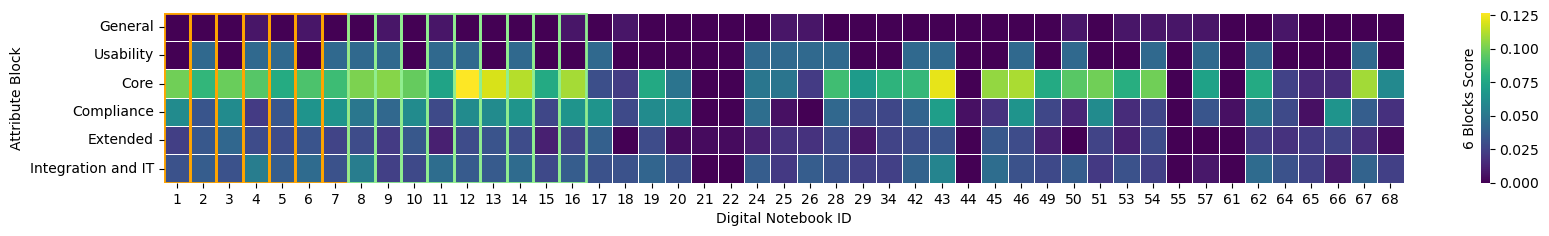

In [84]:
import matplotlib.patches as patches

s = overall_scores.columns.get_loc('b1_score')
vs = overall_scores.copy()
row_num = vs.shape[0]
vs.index = np.arange(1, row_num+1)
vs = vs[vs['overall_score']>0]

plt.figure(figsize=(20,2.5))
plotpart = vs.iloc[:,s:s+6].T

ax = sns.heatmap(plotpart, annot=False, cmap='viridis',linewidth=.4)

new_labels = ['General', 'Usability', 'Core', 'Compliance', 'Extended', 'Integration and IT']
ax.set_yticklabels(new_labels)  
ax.set_ylabel('Attribute Block')
ax.set_xlabel('Digital Notebook ID')

cbar = ax.collections[0].colorbar #add a label to the colourbar
cbar.set_label('6 Blocks Score',labelpad=-55)

for col in range(0,7):
    ax.add_patch(patches.Rectangle((col, 0), 1, plotpart.shape[0], fill=False, edgecolor='orange', lw=2))

for col in range(7,16):
    ax.add_patch(patches.Rectangle((col, 0), 1, plotpart.shape[0], fill=False, edgecolor='lightgreen', lw=2))
plt.subplots_adjust(bottom=0.2)
plt.savefig('heatmap_6blocks.png')


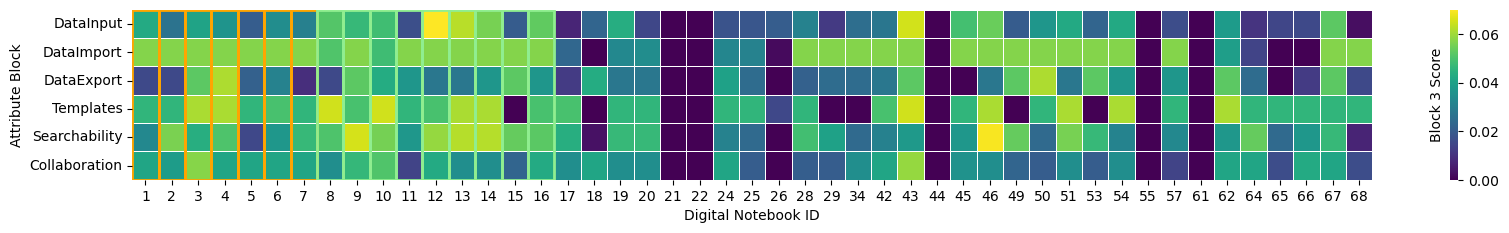

In [78]:
vs['DataInput_score'] = L1_weight['CF-01']*overall_scores['CF_01_L2_score']
vs['DataImport_score'] = L1_weight['CF-02']*overall_scores['CF_02_L2_score']  
vs['DataExport_score'] = L1_weight['CF-04']* overall_scores['CF_04_L2_score']
vs['Templates_score'] = L1_weight['CF-05']* overall_scores['CF_05_L2_score'] 
vs['Searchability_score'] = L1_weight['CF-06']*overall_scores['CF_06_L2_score'] 
vs['Collaboration_score'] = L1_weight['CF-07']*overall_scores['CF_07_L2_score']

plotpart2 = vs.loc[:,['DataInput_score','DataImport_score','DataExport_score','Templates_score','Searchability_score','Collaboration_score']].T
plt.figure(figsize=(20,2.5))
max_block2 = round(plotpart2.max().max(),2)
ax2 = sns.heatmap(plotpart2, vmin=0, vmax=max_block2 ,annot=False, cmap='viridis',linewidth=.4)

new_labels2 = ['DataInput', 'DataImport', 'DataExport', 'Templates', 'Searchability', 'Collaboration']
ax2.set_yticklabels(new_labels2)  
ax2.set_xlabel('Digital Notebook ID')
ax2.set_ylabel('Attribute Block')

cbar = ax2.collections[0].colorbar #add a label to the colourbar
cbar.set_label('Block 3 Score',labelpad=-50)

for col in range(0,7):
    ax2.add_patch(patches.Rectangle((col, 0), 1, plotpart2.shape[0], fill=False, edgecolor='orange', lw=2))

for col in range(7,16):
    ax2.add_patch(patches.Rectangle((col, 0), 1, plotpart2.shape[0], fill=False, edgecolor='lightgreen', lw=2))

plt.subplots_adjust(bottom=0.2)
plt.savefig('heatmap_B3.png')

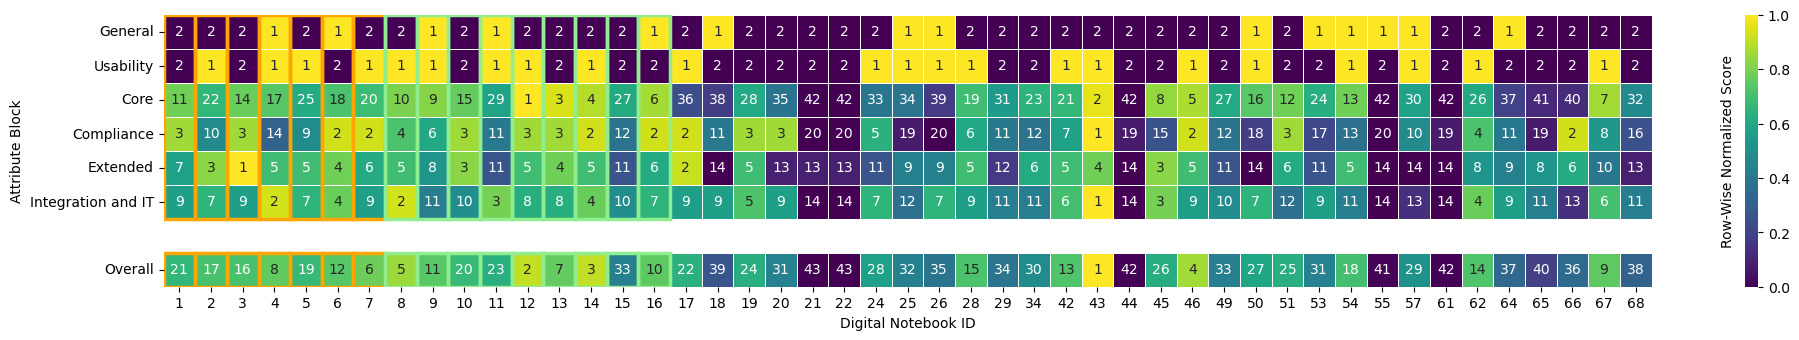

In [50]:
# rank all blocks and overall scores

vs['normalized_b1'] = (vs['b1_score']- vs['b1_score'].min())/(vs['b1_score'].max()-vs['b1_score'].min())
vs['normalized_b2'] = (vs['b2_score']- vs['b2_score'].min())/(vs['b2_score'].max()-vs['b2_score'].min())
vs['normalized_b3'] = (vs['b3_score']- vs['b3_score'].min())/(vs['b3_score'].max()-vs['b3_score'].min())
vs['normalized_b4'] = (vs['b4_score']- vs['b4_score'].min())/(vs['b4_score'].max()-vs['b4_score'].min())
vs['normalized_b5'] = (vs['b5_score']- vs['b5_score'].min())/(vs['b5_score'].max()-vs['b5_score'].min())
vs['normalized_b6'] = (vs['b6_score']- vs['b6_score'].min())/(vs['b6_score'].max()-vs['b6_score'].min())

vs['normalized_overall'] = (vs['overall_score']- vs['overall_score'].min())/(vs['overall_score'].max()-vs['overall_score'].min())

plotpart3 = vs.loc[:,['normalized_b1','normalized_b2','normalized_b3','normalized_b4','normalized_b5','normalized_b6','normalized_overall']].T

separator_index = plotpart3.index.get_loc('normalized_overall')  #add space between blocks and overall
new_row = pd.DataFrame(np.nan, index=["separator"], columns=plotpart3.columns) 
plotpart3 = pd.concat([plotpart3.iloc[:separator_index], new_row, plotpart3.iloc[separator_index:]])


plt.figure(figsize=(24,4))
ax3 = sns.heatmap(plotpart3, annot=plotpart3.rank(axis="columns",method='dense', ascending=False), cmap='viridis',linewidth=.4)


new_labels3 = ['General', 'Usability', 'Core', 'Compliance', 'Extended', 'Integration and IT','','Overall']
ax3.set_yticklabels(new_labels3,rotation=360)  

ax3.set_ylabel('Attribute Block')
ax3.set_xlabel('Digital Notebook ID')

cbar = ax3.collections[0].colorbar #add a label to the colourbar
cbar.set_label('Row-Wise Normalized Score',labelpad=-50)

for col in range(0,7): #highlight active notebooks (green) and shortlist (orange/yellow)
    ax3.add_patch(patches.Rectangle((col, 0), 1, plotpart3.shape[0]-2, fill=False, edgecolor='orange', lw=2.5))
    ax3.add_patch(patches.Rectangle((col, plotpart3.shape[0]-1), 1, 1, fill=False, edgecolor='orange', lw=2.5))

for col in range(7,16):
    ax3.add_patch(patches.Rectangle((col, 0), 1, plotpart3.shape[0]-2, fill=False, edgecolor='lightgreen', lw=2.5))
    ax3.add_patch(patches.Rectangle((col, plotpart3.shape[0]-1), 1, 1, fill=False, edgecolor='lightgreen', lw=2.5))
  
plt.subplots_adjust(bottom=0.2)

ticks = ax3.yaxis.get_major_ticks() #remove ytick of blank row
ticks[6].tick1line.set_markersize(0)



plt.savefig('normalized_heatmap.png',dpi=300)

In [ ]:

annot = new_row = pd.DataFrame('', index=plotpart3.index, columns=plotpart3.columns) #only overall row shows the rank
annot.loc['normalized_overall'] = plotpart3.loc['normalized_overall'].rank(method='dense', ascending=False).astype(int)


plt.figure(figsize=(24,4))
ax4 = sns.heatmap(plotpart3, annot=annot, cmap='coolwarm',fmt='',linewidth=.4)

ax4.set_yticklabels(new_labels3,rotation=360)  

ax4.set_ylabel('Attribute Block')
ax4.set_xlabel('Digital Notebook ID')

cbar = ax4.collections[0].colorbar #add a label to the colourbar
cbar.set_label('Normalized Score',labelpad=-50)

for col in range(0,7): #highlight active notebooks (green) and shortlist (orange/yellow)
    ax4.add_patch(patches.Rectangle((col, 0), 1, plotpart3.shape[0]-2, fill=False, edgecolor='yellow', lw=2.5))
    ax4.add_patch(patches.Rectangle((col, plotpart3.shape[0]-1), 1, 1, fill=False, edgecolor='yellow', lw=2.5))

for col in range(7,16):
    ax4.add_patch(patches.Rectangle((col, 0), 1, plotpart3.shape[0]-2, fill=False, edgecolor='lightgreen', lw=2.5))
    ax4.add_patch(patches.Rectangle((col, plotpart3.shape[0]-1), 1, 1, fill=False, edgecolor='lightgreen', lw=2.5))
  
plt.subplots_adjust(bottom=0.2)

ticks = ax4.yaxis.get_major_ticks() #remove ytick of blank row
ticks[6].tick1line.set_markersize(0)

plt.savefig('normalized_heatmap2.png',dpi=300)


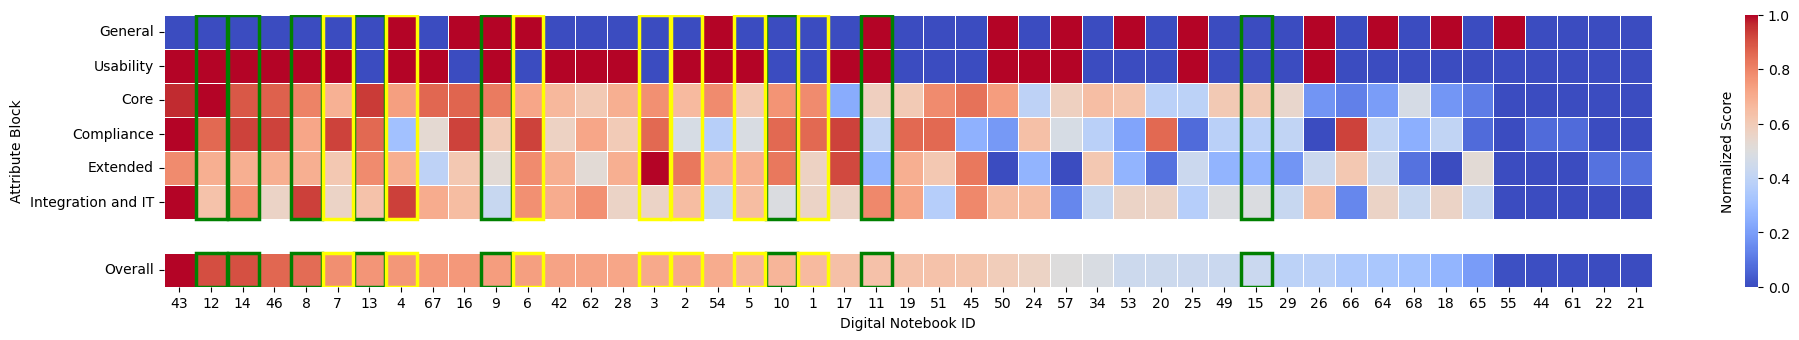

In [37]:
#creat heap map with ordered data

vs2 = vs.sort_values('normalized_overall',ascending = False)

plotpart4 = vs2.loc[:,['normalized_b1','normalized_b2','normalized_b3','normalized_b4','normalized_b5','normalized_b6','normalized_overall']].T

separator_index = plotpart4.index.get_loc('normalized_overall')  #add space between blocks and overall
new_row = pd.DataFrame(np.nan, index=["separator"], columns=plotpart4.columns) 
plotpart4 = pd.concat([plotpart4.iloc[:separator_index], new_row, plotpart4.iloc[separator_index:]])

plt.figure(figsize=(24,4))

ax5 = sns.heatmap(plotpart4, cmap='coolwarm',fmt='',linewidth=0.4)
ax5.set_yticklabels(new_labels3,rotation=360)  

ax5.set_ylabel('Attribute Block')
ax5.set_xlabel('Digital Notebook ID')

cbar = ax5.collections[0].colorbar #add a label to the colourbar
cbar.set_label('Normalized Score',labelpad=-50)

for id in range(8,16):
    ax5.add_patch(patches.Rectangle((plotpart4.columns.get_loc(id)+0.03, 0), 1-0.03, plotpart4.shape[0]-2, fill=False, edgecolor='green', lw=2.5))
    ax5.add_patch(patches.Rectangle((plotpart4.columns.get_loc(id)+0.03, plotpart4.shape[0]-1), 1-0.03, 1, fill=False, edgecolor='green', lw=2.5))
  
for id in range(1,8): #highlight active notebooks (green) and shortlist (orange/yellow)
    ax5.add_patch(patches.Rectangle((plotpart4.columns.get_loc(id)+0.03, 0), 1-0.03, plotpart4.shape[0]-2, fill=False, edgecolor='yellow', lw=2.5))
    ax5.add_patch(patches.Rectangle((plotpart4.columns.get_loc(id)+0.03, plotpart4.shape[0]-1), 1-0.03, 1, fill=False, edgecolor='yellow', lw=2.5))

plt.subplots_adjust(bottom=0.2)

ticks = ax5.yaxis.get_major_ticks() #remove ytick of blank row
ticks[6].tick1line.set_markersize(0)

plt.savefig('normalized_heatmap_ordered.png',dpi=300)
